# Data Analysis

Data analysis notebook for the results of the `DINCAE.jl` model training

In [1]:
import xarray
import numpy as np
import matplotlib.pyplot as plt

In [2]:
i = 3 # Index of the trial to analyze
base_folder = f"./results/trial_{i}/"

result = xarray.open_dataset(f"{base_folder}/data-avg.nc") # Model output
# subset = xarray.open_dataset(f"{base_folder}/modis_subset.nc") # Raw data
cleanup = xarray.open_dataset(f"{base_folder}/modis_cleanup.nc") # Cleaned data (pixels with quality flags > 3 or temperature > 40 removed)
cleanup_clouds = xarray.open_dataset(f"{base_folder}/modis_cleanup_add_clouds.nc") # Cleaned data with simulated clouds added

In [3]:
# Extracting the relevant data arrays

result_sst = result["sst"].values
# subset_sst = subset["sst"].values
cleanup_sst = cleanup["sst"].values
cleanup_clouds_sst = cleanup_clouds["sst"].values
sea_mask = cleanup_clouds["mask"].values.astype(bool) # 1 = water, 0 = land

N = result_sst.shape[0]

result_sst.shape, cleanup_sst.shape, cleanup_clouds_sst.shape, sea_mask.dtype, sea_mask.shape

((7149, 106, 149),
 (7149, 106, 149),
 (7149, 106, 149),
 dtype('bool'),
 (106, 149))

In [4]:
# Calculate in which days the clouds were applied

added_clouds = []

for i in range(N):
    missing_values = sum(np.isnan(cleanup_sst[i].flatten()))
    missing_values_clouds = sum(np.isnan(cleanup_clouds_sst[i].flatten()))
    if missing_values_clouds > missing_values:
        added_clouds.append(i)
        
print("Added clouds in days:\n", added_clouds)

Added clouds in days:
 [4, 6, 7, 11, 21, 33, 37, 42, 49, 56, 58, 59, 61, 63, 66, 67, 69, 71, 72, 73, 75, 76, 77, 86, 88, 90, 93, 96, 98, 100, 110, 113, 116, 118, 119, 123, 127, 133, 137, 141, 145, 148, 152, 154, 158, 159, 160, 161, 164, 165, 166, 167, 171, 175, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 193, 195, 196, 197, 198, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 217, 220, 224, 225, 226, 227, 228, 229, 231, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 249, 251, 252, 254, 256, 265, 267, 268, 276, 277, 282, 285, 286, 293, 296, 297, 298, 302, 304, 306, 308, 321, 325, 327, 333, 337, 338, 340, 343, 346, 348, 353, 360, 365, 370, 376, 377, 379, 381, 382, 385, 392, 393, 394, 397, 400, 403, 404, 415, 417, 418, 424, 425, 426, 427, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 455, 456, 457, 459, 460, 461, 463, 464, 465, 466, 470, 471, 472, 473, 474, 476, 477, 478

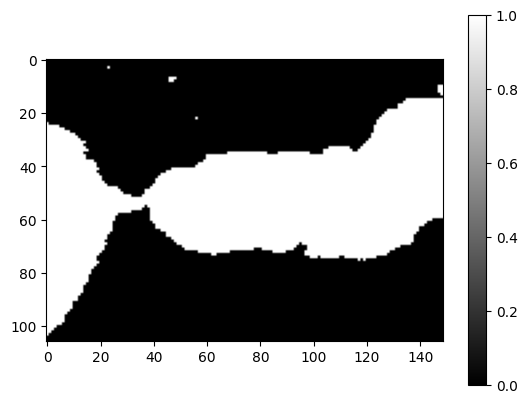

In [5]:
plt.imshow(sea_mask, cmap='gray')
plt.colorbar()

Chosen index for reconstruction: 7144
Days used for mean reconstruction:
 [7143, 7145]
Min: 13.550389289855957, Max: 20.466402053833008


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_56233/4235678244.py:16: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0)


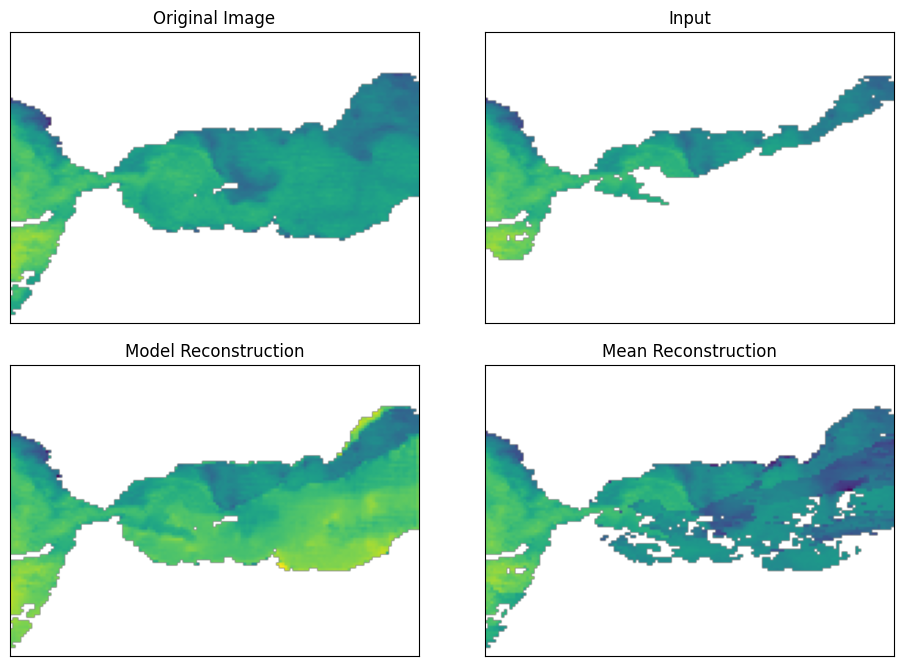

In [ ]:
i = added_clouds[-4] # use one day with added clouds for reconstruction
print(f"Chosen index for reconstruction: {i}")
time_window = 3 # Specify the time window for reconstruction
n_days = time_window // 2 # Get the number of days before and after the current day
reconstruction_days = [x for x in range(i - n_days, i + n_days + 1) if x != i]
print("Days used for mean reconstruction:\n", reconstruction_days)

# Calculate where the clouds were applied, only considering water areas
# The applied clouds are where cleanup_clouds_sst is NaN but and the original image isn't
cloud_mask = np.isnan(cleanup_clouds_sst[i]) & ~np.isnan(cleanup_sst[i])

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_img = np.where(cloud_mask, result_sst[i], cleanup_sst[i])

# Calculate the mean of the surrounding days
mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0)
# Calculate the reconstructed image using the mean of the surrounding days where clouds were added
reconstructed_mean_img = np.where(cloud_mask, mean_res, cleanup_sst[i])

# Calculate the min and max values for consistent color scaling
vmin = np.min([np.nanmin(reconstructed_img), np.nanmin(cleanup_clouds_sst[i]), np.nanmin(reconstructed_mean_img)])
vmax = np.max([np.nanmax(reconstructed_img), np.nanmax(cleanup_clouds_sst[i]), np.nanmax(reconstructed_mean_img)])
print(f"Min: {vmin}, Max: {vmax}")

fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

axs[0, 0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Original Image')

axs[0, 1].imshow(cleanup_clouds_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Input')

axs[1, 0].imshow(reconstructed_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Model Reconstruction')

axs[1, 1].imshow(reconstructed_mean_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Mean Reconstruction')

plt.tight_layout()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

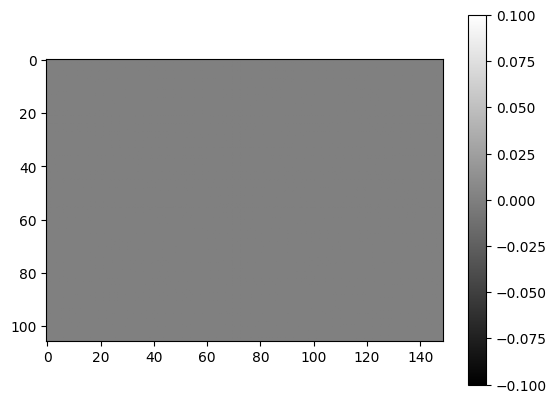

In [7]:
plt.imshow(np.isnan(cleanup_clouds_sst[i]) & ~np.isnan(cleanup_sst[i]), cmap='gray')
plt.colorbar()

In [8]:
# Calculate RMSE between the reconstructed and original images
RMSE_model = np.sqrt(np.nanmean((reconstructed_img - cleanup_sst[i]) ** 2))
RMSE_mean = np.sqrt(np.nanmean((reconstructed_mean_img - cleanup_sst[i]) ** 2))

print(f"RMSE:\n Model: {RMSE_model}\n Mean: {RMSE_mean}")

RMSE:
 Model: 0.0
 Mean: 0.0


## Calculate mean RMSE

Calculate the mean RMSE of the dataset, using:
- The output of the model
- The mean of the previous and following days

In [9]:
# Calculate where the clouds were applied, only considering water areas
mask = np.isnan(cleanup_clouds_sst) & ~np.isnan(cleanup_sst)

In [10]:
RMSE_rec = []
RMSE_mean = []

for i in range(n_days, N - n_days):
   
    if not mask[i].any(): # If no clouds were applied, skip this iteration
        continue

    diff = (result_sst[i] - cleanup_sst[i])[mask[i]] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue
    rec = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for reconstruction

    reconstruction_days = [x for x in range(i - n_days, i + n_days + 1) if x != i]
    mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0) # Calculate the mean of the previous and following days
    diff = (mean_res - cleanup_sst[i])[mask[i]] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue

    mn = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for mean reconstruction

    if np.isnan(rec) or np.isnan(mn):
        print(f"Skipping {i} due to NaN values in RMSE calculations.")
        continue
        
    RMSE_rec.append(rec)
    RMSE_mean.append(mn)

print("Number of valid RMSE values:", len(RMSE_rec))
print("Mean RMSE Reconstruction:", np.mean(RMSE_rec))
print("Mean RMSE Mean:", np.mean(RMSE_mean))


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_56233/4164045493.py:15: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[reconstruction_days], axis=0) # Calculate the mean of the previous and following days


Number of valid RMSE values: 974
Mean RMSE Reconstruction: 1.9771897
Mean RMSE Mean: 0.898761


## Plot the loss

In [11]:
with open(base_folder + 'loss.txt', 'r') as f:
    loss = f.read()
    
loss = loss.split('\n')

loss = [float(x) for x in loss if x]  # Convert to float and remove empty strings

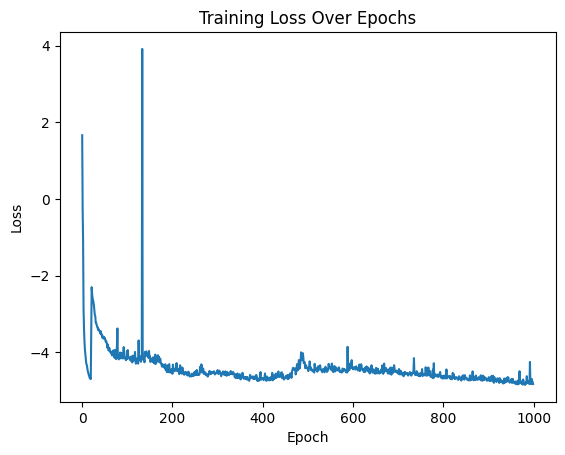

In [12]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()